<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - GPT2 from Scratch! <br>
<font color=696880 size=4>
            Designer: Shaygan Adim
    
    

**Name**:  
  
**Student Code**:

# Overview

In this project, you will implement a scaled-down version of OpenAI's GPT-2 architecture from scratch using PyTorch. You'll train this model on the Snappfood comments with sentiment labels. The goal is to create a generative language model that can produce synthetic Persian comments with controllable sentiment (positive or negative).

# Learning Objectives

* Understanding and implementing transformer-based language model architectures  
* Learning how to control text generation using special tokens  
* Visualizing and analyzing training progress  

# Dataset

You'll work with a Persian dataset containing Snappfood comments:  

* The dataset texts are normalized (No need for any normalizations)
* Each comment has a sentiment label (1 for positive, 0 for negative)
* The dataset contains text with variations in length and style

# Tokenizer and model

You should use one of the sota open-source LLM tokenizers. I strongly recommend using Llama 3.3 tokenizer or Gemma-2 tokenizer as they're better than the others in Persian language. (There is no need to implement a tokenizer yourself.)

Your model should have the exact srtructure of GPT-2:  
  
<img src="GPT-2.png" alt="" width="600" height="800">
  
For the model to be able to smoothly be trained, you should use the config below:

* **Embedding Dimension**: 192 (reduced from 768 in original GPT-2)
* **Layers**: 3 transformer blocks (reduced from 12 in original GPT-2)
* **Attention Heads**: 3 (reduced from 12 in original GPT-2)
* **Context Window**: 128 tokens (reduced from 1024 in original GPT-2)

Moreover, unlike the original Transformer paper that used fixed sinusoidal position encodings, GPT-2 (and your implementation) should use learnable position embeddings:
1. You should create an embedding table of size [n_positions, n_embd] where:

    * n_positions is the maximum sequence length (128 in our model)
    * n_embd is the embedding dimension (192 in our model)
2. For each position in the sequence (0 to sequence_length-1), we look up the corresponding embedding vector.

3. These position embeddings are added to the token embeddings before being passed through the transformer blocks.

# Some notes:

* Be aware that you will be questioned about your solution to this assignment in-person. Thus, build a solid understanding through out solving this assignment.
* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You need GPU for this assignment. Use can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Instructions provided for you in TODO sections ARE NOT the only things that you should do in those parts. They're just some important bullet points that your code should have.
* The final results (Inference section) should have the minimum quality of the samples already generated in the notebook.

# Importing

In [ ]:
# Data loading and manipulation
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenization utilities
from transformers import AutoTokenizer
from huggingface_hub import login

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization tool
import matplotlib.pyplot as plt

# Runtime utilities
import math
import time
from tqdm import tqdm

# Typing tool
from typing import Dict, Optional, Any

# Downloading and loading the data

In this section we read and load the data from [here](https://www.kaggle.com/datasets/mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis).

You can also see some information about the data in the next cell. In the end, we only want the label and cleaned columns.

In [ ]:
# TODO: Download the dataset using kagglehub

path = None

print("Path to dataset files:", path)

raw_corpus = pd.read_csv(path + "/cleaned_snappfood.csv")

In [3]:
raw_corpus.info()
raw_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


,comment,label,comment_length,comment_cleaned
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,0,47,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,1,132,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,0,89,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,1,99,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,شیرینی وانیلی فقط یک مدل بود.,1,29,شیرینی وانیلی فقط یک مدل بود


In [4]:
raw_corpus = raw_corpus[["comment_cleaned", "label"]]

# Downloading and loading the tokenizer (5 Points)

In this section you need to load your tokenizer from hugging face. I recommend [this](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) or [this](https://huggingface.co/google/gemma-2-27b-it).
Keep in mind that you might need to login first using your hugging face access token and also sign an agreement thing in model's page to be able to access the model and it's tokenizer.

In [ ]:
# TODO: Set up authentication (if needed) and initialize a tokenizer
#  Use the login() function to authenticate with your Hugging Face token (if needed)
#  Initialize a tokenizer using the AutoTokenizer class

tokenizer = None

In the cell below, add two special tokens to the vocabulary of the tokenizer indicating positivity or negativity of a comment. We will add these tokens manually as the first token of each comment so model will understand the difference between positive and negative comments.

In [6]:
# TODO: Add custom special tokens to the tokenizer

# 1. Create a dictionary named 'special_tokens' with a key 'additional_special_tokens' that contains a list of two special tokens for positivity and negativity
# 2. Add these tokens to the vocabulary

# These special tokens will be used to tell the model what sentiment we're expecting during training and inference.

special_tokens = None
tokenizer.add_special_tokens(special_tokens)

2

## Dataset and Dataloader (10 Points)

Create a custom Dataset class for the data

In [7]:
class CommentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.comments = dataframe['comment_cleaned'].tolist()
        self.labels = dataframe['label'].tolist()
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.comments)

    def __getitem__(self, idx: int) -> dict:
        # TODO: Process a single item from the dataset
        # This method should:
        # 1. Get the appropriate label and comment at the given index
        # 2. Create a prefix based on the sentiment
        # 3. Tokenize the text

        input_ids = None
        attention_mask = None
        labels = None
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

Create train and validation datasets and dataloaders and also split the data

In [8]:
# TODO: Prepare the training and validation datasets and dataloaders
#
# 1. Split the raw_corpus dataframe into training and validation sets with a suitable ratio
# 2. Create dataset instances using the CommentDataset class:
# 3. Create DataLoader instances

train_df, val_df = None, None

train_dataset = None
val_dataset = None

train_loader = None
val_loader = None

## Model implementation (35 Points)

In this section you should implement the model architecture completely from scratch. No pre-defined torch or other libraries tools are allowed. (Even for the attention mechanism)

In [9]:
class GPT2Config:
    def __init__(
        self,
        vocab_size,
        n_positions,  
        n_embd,
        n_layer,
        n_head,
        n_inner=None,
        activation_function="gelu",
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        bos_token_id=None,
        eos_token_id=None,
    ):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = 4 * n_embd if n_inner is None else n_inner
        self.activation_function = activation_function
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

In [10]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.attn_pdrop

        # TODO: Initialize the query, key, value projection layer
        # Create a single linear layer (c_attn) that projects the input embeddings to query, key, and value vectors
        # The output dimension should be 3 * config.n_embd
        
        # TODO: Initialize the output projection layer
        # Create a linear layer (c_proj) that projects the attention output back to the embedding dimension
        
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        # TODO: Create the causal attention mask
        # Register a buffer named "mask" with shape (config.n_positions, config.n_positions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality

        # TODO: Implement the multi-head attention mechanism
        # 1. Project input x to query, key, and value using self.c_attn
        # 2. Compute attention scores:
        # 3. Apply attention weights to values
        # 4. Apply the output projection and residual dropout
        
        y = None
        return y

In [11]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_inner)
        self.c_proj = nn.Linear(config.n_inner, config.n_embd)
        self.dropout = nn.Dropout(config.resid_pdrop)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the feed-forward network forward pass
        
        return x

In [12]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Initialize the components of a transformer block
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the transformer block forward pass with residual connections
        
        return x

In [13]:
class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),
            'wpe': nn.Embedding(config.n_positions, config.n_embd),
            'drop': nn.Dropout(config.embd_pdrop),
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            'ln_f': nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        })

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer['wte'].weight = self.lm_head.weight 

        self.apply(self._init_weights)

    def _init_weights(self, module):
        # TODO: Implement the weight initialization function
        # 1. For Linear and Embedding layers:
        #    - Initialize weights from a normal distribution with mean=0.0 and 
        #      std=self.config.initializer_range
        #    - For Linear layers with bias, initialize the bias to zero
        # 2. For LayerNorm layers:
        #    - Initialize bias to zero
        #    - Initialize weight to ones
        pass

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, 
                labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # TODO: Implement the forward pass
        #
        # 1. Create position indices
        # 2. Compute embeddings
        # 3. Process the input through transformer blocks
        # 4. Apply final layer normalization
        # 5. Compute logits using the language model head
        # 6. Return a dictionary with 'logits' and 'loss' (if calculated)
        logits = None
        loss = None        
        return {'logits': logits, 'loss': loss}

    def generate(self, input_ids: torch.Tensor, max_length: int, 
                temperature: float = 1.0, top_k: int = 0, top_p: float = 0.9) -> torch.Tensor:
        # TODO: Implement text generation with various decoding strategies
        # This method should generate text auto-regressively using the trained model
        # with temperature, top-k, and nucleus (top-p) sampling techniques.
        #
        # 1. Set the model to evaluation mode
        # 2. Loop to generate 'max_length' new tokens:
        #    a. Run the forward pass to get logits for the current sequence
        #    b. Extract logits for the last token and apply temperature scaling        #
        #    c. Apply top-k sampling if top_k > 0:
        #    d. Apply nucleus (top-p) sampling if top_p < 1.0:
        # 3. Return the complete generated sequence
        
        return input_ids

## Train and evaluation (25 Points)

Now you should implement the train and evaluation functions.

In [14]:
def train_epoch(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, 
               scheduler, device: torch.device, log_interval: int) -> tuple:
    # TODO: Implement the training loop for a single epoch

    total_loss = None
    step_nums = None
    step_losses = None
    
    return total_loss / len(data_loader), step_nums, step_losses

def evaluate(model: nn.Module, data_loader: DataLoader, 
            device: torch.device, log_interval: int) -> tuple:
    # TODO: Implement the evaluation loop
    total_loss = None
    step_nums = None
    step_losses = None
    return total_loss / len(data_loader), step_nums, step_losses

In [ ]:
config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=128,
    n_embd=192,
    n_layer=3,
    n_head=3,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2(config)
model.to(device)

Now train the model for 3 to 5 epochs. It's recommended to use a suitable learning rate scheduler (For example, cosine). Also save training and validation loss periodically.

In [16]:
# TODO: Set up and run the training loop

# Implement the main training loop:
#    For each epoch:
#       - Call train_epoch to train for one epoch and get losses and step information
#       - Store the average epoch loss in epoch_train_losses
#       - Update step tracking, adjusting step numbers for the current epoch
#       - Call evaluate to validate the model and get validation losses
#       - Store the average validation loss in epoch_val_losses
#       - Update validation step tracking
#       - Print the training and validation losses for the epoch


epochs = 5

optimizer = None
total_steps = len(train_loader) * epochs
scheduler = None

epoch_train_losses = []
epoch_val_losses = []
all_train_step_losses = []
all_train_step_nums = []
all_val_step_losses = []
all_val_step_nums = []

best_val_loss = float('inf')
for epoch in range(epochs):
    pass

Epoch 1


Evaluating: 100%|██████████| 825/825 [00:10<00:00, 76.82it/s]


Train Loss: 4.9686, Val Loss: 3.9754
Saved best model!
Epoch 2


Evaluating: 100%|██████████| 825/825 [00:10<00:00, 75.28it/s]


Train Loss: 3.8201, Val Loss: 3.6054
Saved best model!
Epoch 3


Evaluating: 100%|██████████| 825/825 [00:11<00:00, 74.53it/s]


Train Loss: 3.5890, Val Loss: 3.4707
Saved best model!
Epoch 4


Evaluating: 100%|██████████| 825/825 [00:10<00:00, 75.59it/s]


Train Loss: 3.4930, Val Loss: 3.4163
Saved best model!
Epoch 5


Evaluating: 100%|██████████| 825/825 [00:10<00:00, 76.45it/s]


Train Loss: 3.4565, Val Loss: 3.4078
Saved best model!


Plot the training and validation loss in each epoch and also in each steps you saved before.

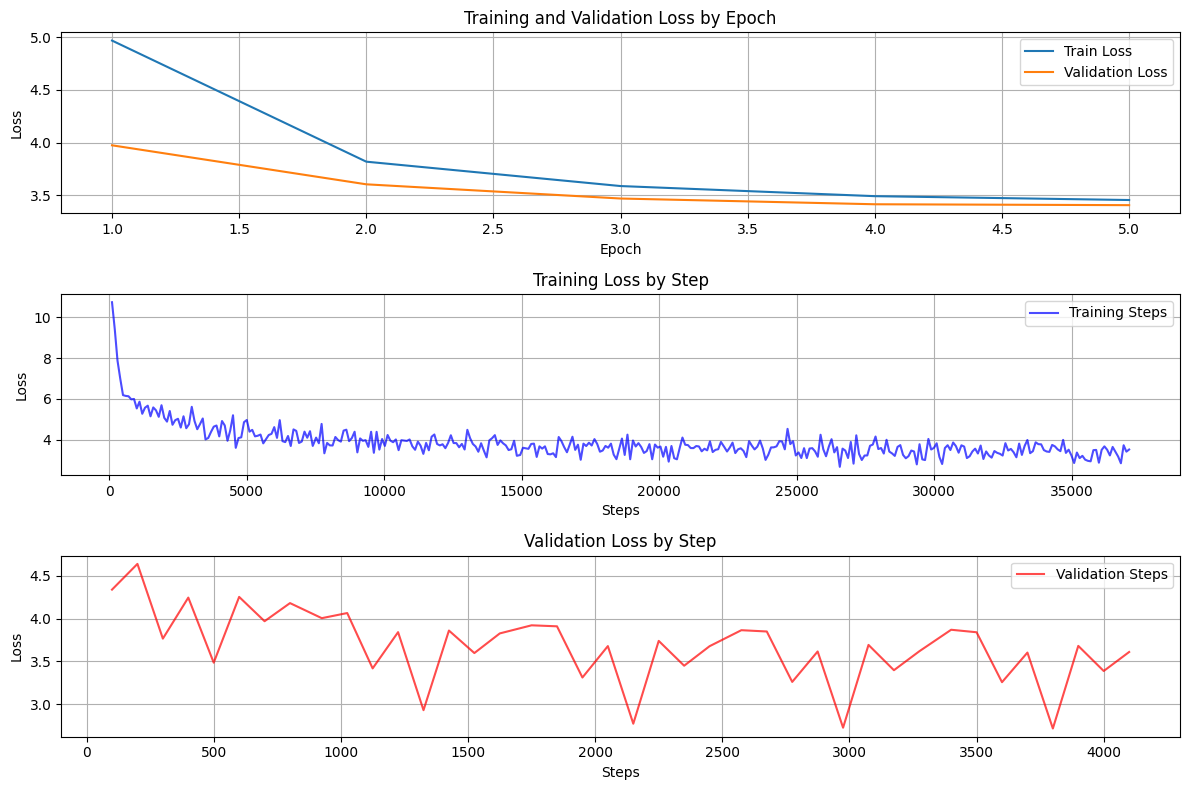

In [19]:
# TODO: Visualize the training and validation results

# Create three subplots:
#    a. Plot epoch-level training and validation losses
#    b. Plot step-level training losses
#    c. Plot step-level validation losses

# Inference (15 Points)

Complete the function below to generate comments (positive or negative) 

In [21]:
def generate_comment(model: nn.Module, tokenizer: Any, sentiment: str, max_length: int = 50) -> str:
    # TODO: Implement text generation with sentiment control
    # 1. Create the appropriate prefix based on the sentiment parameter
    # 2. Generate text using the model's generate method

    generated_text = None
    return generated_text

Generate 10 positive and 10 negative comments and evaluate your results

In [25]:
# TODO: Demonstrate the model's sentiment-controlled text generation

model.eval()

for _ in range(10):
#    a. Generate a positive comment using the generate_comment function:
#    b. Generate a negative comment using the generate_comment function:
    pass

Positive Comment:
 طعم غذا خوب بود و به موقع رسید دستم رسید و پیک هم را از اس غذا راضی بودم و اسنپ فود و سفارش هم به هم رسید و هم بابت رستوران سفارش و با تشکر از و غذا و با کیفیت و

Negative Comment:
 بسیار سرد به دست من از اس بیپ فود راضی بودم غذا رو بنده سفارش دادم و سفارش به دستمون رسید و بی فود و غذا راضی بودم و پیت و با توجه به نظر من رسید از این رستوران

Positive Comment:
 خوش مثل همیشه ممنون از رستوران سفارش به دستم به موقع و اسنپ فود و از اسنپ فود غذا بسیار مودب و با کیفیت و و خوشم بود و به دست من و به موقع به دست م م

Negative Comment:
 پیتزا و بسیار بدم من مشتریان کنید کیفیت این رستوران غذا رو هم کیفیت و کیفیت غذا خوب بود و مزه و حجم غذا هم واقعا پایین بود و کیفیت غذا رو غذا رو به این رستوران سفارش نمیشه از این رست

Positive Comment:
 نانهای به دست رسید پیتزا هم پیتزا خوب بود در کل خوب بود و و خمیر پیتزا هم به نسبت به قیمتش نسبت به کیفیت و کیفیت غذا خوب بود از سفارش غذا به قیمت خیلی خوب بود با کیفیت غذا

Negative Comment:
 غذا سرد رسید و پیتزا سرد بود و پیتزا گرم بود به قیمت 

## Inference Time Hyperparameters (10 Points)

Play with these parameters for the best results:
  
temperature, top_k, top_p

Briefly report what you saw and try to explain why is it happening. What is the effect of each one?

**Your Report**:  